# Project 3
Comparing r/SuicideWatch and r/MentalHealth

### Introduction

We from Resilience.AI, leader in mental health machine learning diagonstic tecnhologies. We have entered into a partership with Reddit to improve the mental health support offered to users on Reddit.

Reddit has been a favored platform as a place for mental health community support. There are many subreddits that cater to various mental health issues, and Reddit has implemented a report feature that allows other Reddit users to flag posts that exhibit suicide or self-harm idealation. [[1]](https://www.fastcompany.com/90472072/reddit-will-now-automatically-connect-potentially-suicidal-users-with-a-hotline) Users can flag a post using this function, and Reddit will send a private message to the author of the post, links to resources where they can get mental health support.

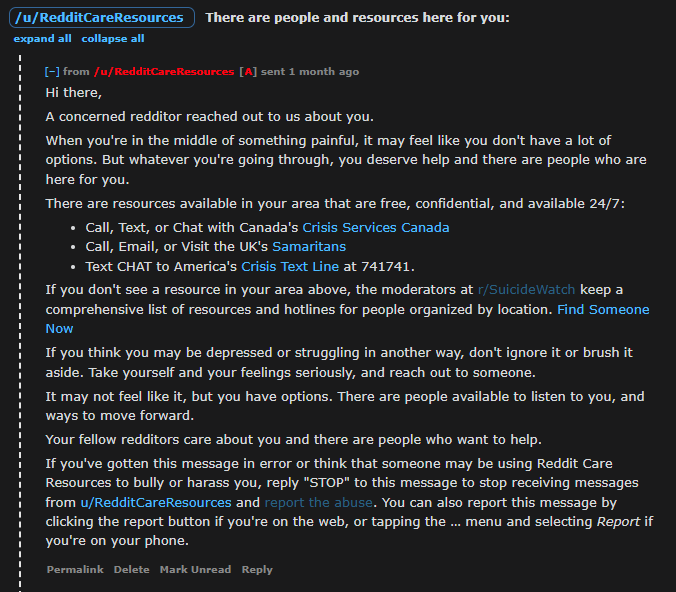

However this is solution relies on the altruism of fellow Reddit users, which in reality, with any online community there would be malicious actors. There have been complaints of abuse of this button, where the report button was used to harass instead of help. [[2]](https://www.reddit.com/r/ModSupport/comments/p3kxe0/abuse_of_the_suicide_or_self_harm_report_button/)

Hence we aim to create a classification model, that we can use to filter out suicide content reports that clearly are irrelevant, and identify those that are clearly legitimate uses of the report function. We would be aiming to optimize for specificity, to reduce the likelihood of false positives. A further application of this model would be to identify borderline cases which can be reviewed by a dedicated team.
 
We have selected r/SuicideWatch and r/MentalHealth and we will scrape posts using the PushShift API from these subreddits to train the classification model with. As r/SuicideWatch is a subreddit which specifically caters support for people with suicidal thoughts, and r/MentalHealth is a more general subreddit that supports Mental Health issues in general, these would be ideal for the training of this model.

In [1]:
# Import Libaries
import requests
import pandas as pd
import conda
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
# Set 1 hour delay to allow time for moderators to filter new posts
dtime = datetime.now() - timedelta(hours=1)
unixtime = time.mktime(dtime.timetuple())
unixtime

1648868740.0

In [3]:
# Initialize list to store scraped data
posts_suicidewatch = []

In [80]:
# Initialize list to store scraped data
posts_mentalhealth = []

In [57]:
# Define function to query PushShift API
def query_pushshift(subreddit='suicidewatch', size=100, before='', add_to_list=''):
    '''Connects to the PushShift API to query submission posts on a specified subreddit'''
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {
        'subreddit': subreddit,
        'size': size,
        'before': before,
        #'score': '> 1',
        'fields': ['author', 
                   'created_utc',
                   'id',
                   'score',
                   'upvote_ratio',
                   'num_comments',
                   'title',
                   'selftext',
                   'link_flair_text',
                   'removed_by_category']
                   }
    res = requests.get(url, params)
    status = res.status_code
    if status != 200:
        raise ConnectionError(f'Error {status} connecting to pushshift api')
    data = res.json()
    new_posts = data['data']
    add_to_list.extend(new_posts)

In [58]:
# Define function to loop queries in batches of up to 100 submissions per query
def get_submissions(n=10000, subreddit='suicidewatch',before='', add_to=''):
    '''loops to call the query_pushshift function to query submission posts in reverse chronological 
    order with reference to the earliest entry in the variable 'posts' in multiples of 100
    n - total number of submissions to retrieve
    subreddit - subreddit to get from
    before - 
    '''
    posts_remaining = n
    add_to_list=add_to
    earliest_post_time = ''
    if len(add_to) > 0:
        earliest_post_time = add_to[-1]['created_utc']
    else: 
        earliest_post_time = ''
        
    while posts_remaining > 0:
        if posts_remaining > 100:
            query_size = 100
            try:
                query_pushshift(subreddit=subreddit, size=query_size, before=earliest_post_time, 
                                add_to_list=add_to_list)
            except:
                query_pushshift(subreddit=subreddit, size=query_size, before=earliest_post_time, 
                                add_to_list=add_to_list)
            print(f'queried {n - posts_remaining}, remaining {posts_remaining}   ', end="\r", flush=True)
            posts_remaining = posts_remaining - query_size
            earliest_post_time = add_to[-1]['created_utc']
            
        else:
            query_size = posts_remaining
            query_pushshift(subreddit=subreddit, size=query_size, before=earliest_post_time, 
                            add_to_list=add_to_list)
            posts_remaining = posts_remaining - query_size
            print(f'queried {query_size}                    ', end="\r", flush=True)
            time.sleep(1)
    print(f'queries completed                          ', end="\r", flush=True)
    return add_to_list

In [7]:
# First scraping of data
suicidewatch1 = get_submissions(n=10000, subreddit='suicidewatch', add_to=posts_suicidewatch)

In [8]:
# Convert to DataFrame
df_suicidewatch1 = pd.DataFrame(posts_suicidewatch)

In [9]:
# Check length after scrape
df_suicidewatch1.shape

(9993, 9)

Initial data cleaning: Filter out blank `selftext` and posts that are removed or deleted

In [10]:
# Deselect rows with selftext == NaN OR blank '', AND is removed_by_category == NaN
df_suicidewatch1 = df_suicidewatch1[(~((df_suicidewatch1['selftext'].isna())|
          (df_suicidewatch1['selftext']==""))
        ) &
      df_suicidewatch1['removed_by_category'].isna()
     ]

In [11]:
# Drop submission selftexts that are duplicates
df_suicidewatch1 = df_suicidewatch1.drop_duplicates('selftext')

In [12]:
df_suicidewatch1.shape

(7440, 9)

In [13]:
df_suicidewatch1.describe()

,created_utc,num_comments,score,upvote_ratio
count,7.440000e+03,7440.000000,7440.000000,7440.000000
mean,1.647919e+09,0.036828,1.039919,0.998487
std,5.458111e+05,0.464047,0.567662,0.022400
min,1.646965e+09,0.000000,0.000000,0.500000
25%,1.647449e+09,0.000000,1.000000,1.000000
50%,1.647918e+09,0.000000,1.000000,1.000000
75%,1.648401e+09,0.000000,1.000000,1.000000
max,1.648872e+09,22.000000,27.000000,1.000000


In [14]:
(12000 - 7434) / (7434/9993)

6137.750605326876

Out of 19965 submissions in the first scraping, we are left with 5514 submissions after removing blanks and deleted/removed row, a proportion of 28%. Hence to get approximately 13500 posts, we would need to scrape additional 29000 posts

In [82]:
# Second scraping of data
suicidewatch2 = get_submissions(n=6200, subreddit='suicidewatch',before='', add_to=posts_suicidewatch)

In [83]:
# Convert to DataFrame
df_suicidewatch2 = pd.DataFrame(suicidewatch2)

In [84]:
# Check length after scrape
df_suicidewatch2.shape

(22380, 9)

Initial data cleaning: Filter out blank `selftext` and posts that are removed or deleted

In [18]:
# Deselect rows with selftext == NaN OR blank '', AND is removed_by_category == NaN
df_suicidewatch2 = df_suicidewatch2[(~((df_suicidewatch2['selftext'].isna())|
          (df_suicidewatch2['selftext']==""))
        ) &
      df_suicidewatch2['removed_by_category'].isna()
     ]

In [19]:
# Drop submission selftexts that are duplicates
df_suicidewatch2 = df_suicidewatch2.drop_duplicates('selftext')

In [20]:
# Check length after cleaning
df_suicidewatch2.shape

(12138, 9)

We would repeat this process for r/mentalhealth

In [85]:
# First scraping of data
posts_mentalhealth = get_submissions(n=17000, subreddit='mentalhealth', add_to=posts_mentalhealth)

In [86]:
# Convert to DataFrame
df_mentalhealth1  = pd.DataFrame(posts_mentalhealth)

In [87]:
# Check length after scrape
df_mentalhealth1.shape

(16988, 10)

In [88]:
# Drop submissions that have no selftext and those that have been removed 
df_mentalhealth1 = df_mentalhealth1[(~((df_mentalhealth1['selftext'].isna())|
          (df_mentalhealth1['selftext']==""))
        ) &
      df_mentalhealth1['removed_by_category'].isna()
     ]

In [89]:
df_mentalhealth1.shape

(15696, 10)

In [90]:
# Drop submission selftexts that are duplicates
df_mentalhealth1 = df_mentalhealth1.drop_duplicates('selftext')

In [91]:
# Check length after scrape
df_mentalhealth1.shape

(15482, 10)

In [92]:
df_mentalhealth1.describe()

,created_utc,num_comments,score,upvote_ratio
count,1.548200e+04,15482.000000,15482.000000,15482.000000
mean,1.646506e+09,1.359062,1.008655,0.999315
std,1.349341e+06,3.078930,0.279900,0.015003
min,1.644163e+09,0.000000,0.000000,0.500000
25%,1.645372e+09,1.000000,1.000000,1.000000
50%,1.646511e+09,1.000000,1.000000,1.000000
75%,1.647664e+09,1.000000,1.000000,1.000000
max,1.648879e+09,214.000000,24.000000,1.000000


Drop column that is no longer needed

In [30]:
# Drop column that is no longer needed
df_suicidewatch2.drop(columns=['removed_by_category'],inplace=True)

In [94]:
# Drop column that is no longer needed
df_mentalhealth1.drop(columns=['removed_by_category'],inplace=True)

Save to CSV file

In [32]:
# Save to CSV
df_suicidewatch2.to_csv('../Data/data_suicidewatch.csv', index=False)

In [96]:
# Save to CSV
df_mentalhealth1.to_csv('../Data/data_mentalhealth.csv', index=False)

In [97]:
df_mentalhealth1.shape

(15482, 9)

In [98]:
df_suicidewatch2.shape

(22380, 9)